## Urban trees: towards a clinical study

## Introduction

### Requirements

In [4]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

### Data

In [5]:
# Source : https://www.data.gouv.fr/fr/datasets/arbres-urbains/
data = pd.read_csv('./data/sgl-arbres-urbains-wgs84.csv')
data.head(5)

,ID_ARBRE,commune,quartier,site,cote_voirie,matricule_arbre,genre_arbre,espece_arbre,controle,situation,...,observation_travaux,type_delai_1,delai_annee_programmation,type_delai_2,delai_preconisation_2,delai_saison_programmation_2,delai_annee_programmation_2,reference_photo,Long,Lat
0,78551-Arbres-001,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,7,Betula,Alba,NaN,Groupe,...,NaN,NaN,NaN,b,NaN,b4,2022.0,259,2.074,48.899
1,78551-Arbres-002,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,8,Betula,Alba,NaN,Groupe,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.074,48.899
2,78551-Arbres-003,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,9,Betula,Alba,NaN,Groupe,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.074,48.899
3,78551-Arbres-004,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,1,Carpinus,Betulus - L. - Fastigiata,NaN,Bosquet,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.073,48.900
4,78551-Arbres-005,Saint Germain en Laye,Quartier 2 - Alsace - Pereire,Carrefour RN13,NaN,2,Carpinus,Betulus - L. - Fastigiata,NaN,Bosquet,...,NaN,NaN,NaN,b,NaN,b4,2022.0,NaN,2.074,48.899


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID_ARBRE                      709 non-null    object 
 1   commune                       709 non-null    object 
 2   quartier                      709 non-null    object 
 3   site                          709 non-null    object 
 4   cote_voirie                   545 non-null    object 
 5   matricule_arbre               709 non-null    int64  
 6   genre_arbre                   709 non-null    object 
 7   espece_arbre                  701 non-null    object 
 8   controle                      11 non-null     float64
 9   situation                     708 non-null    object 
 10  type_sol                      709 non-null    object 
 11  surf_permeable                709 non-null    float64
 12  date_plantation               709 non-null    int64  
 13  class

In [7]:
data.columns

Index(['ID_ARBRE', 'commune', 'quartier', 'site', 'cote_voirie',
       'matricule_arbre', 'genre_arbre', 'espece_arbre', 'controle',
       'situation', 'type_sol', 'surf_permeable', 'date_plantation',
       'classe_age', 'hauteur', 'classe_hauteur', 'diametre',
       'circonference (en cm)', 'classe_circonference', 'port_arbre',
       'vigueur_pousse', 'champignon_collet', 'insecte_collet', 'plaie_collet',
       'observation_collet', 'champignon_tronc', 'insecte_tronc',
       'fissure_tronc', 'rejet_tronc', 'tuteurage_arbre', 'canisse_arbre',
       'plaie_tronc', 'observation_tronc', 'champignon_houppier',
       'insecte_houppier', 'fissure_houppier', 'ecorce_incluse_houppier',
       'bois_mort_houppier', 'plaie_houppier', 'observation_houppier',
       'esperance_maintien', 'contrainte', 'classification_diagnostic',
       'date_diagnostic', 'prescription_1', 'prescription_2', 'prescription_3',
       'observation_travaux', 'type_delai_1', 'delai_annee_programmation',
      

<Axes: >

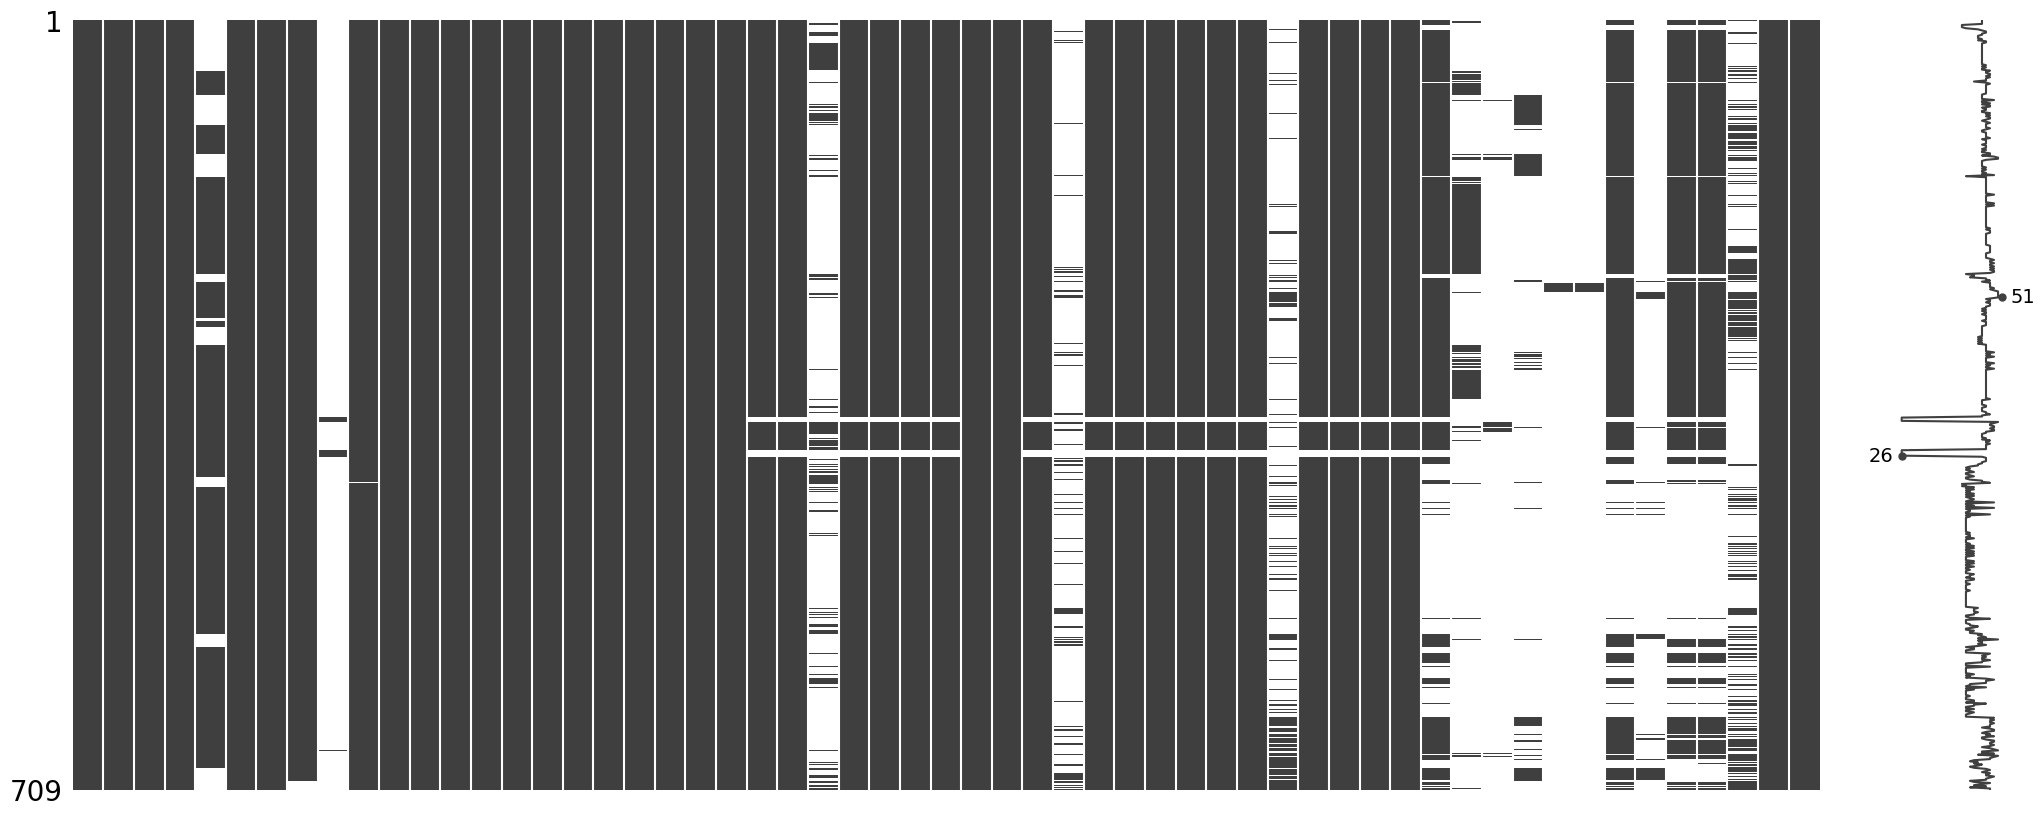

In [8]:
# Missingness
msno.matrix(data)

### Labels

In [9]:
data.classification_diagnostic.unique().shape , data.classification_diagnostic.unique()

((6,), array(['C2', 'C1', 'C3', 'C4', nan, 'C5'], dtype=object))

In [10]:
data.classification_diagnostic.value_counts(dropna=False)

C2     398
C1     237
C3      43
C4      11
NaN     10
C5      10
Name: classification_diagnostic, dtype: int64

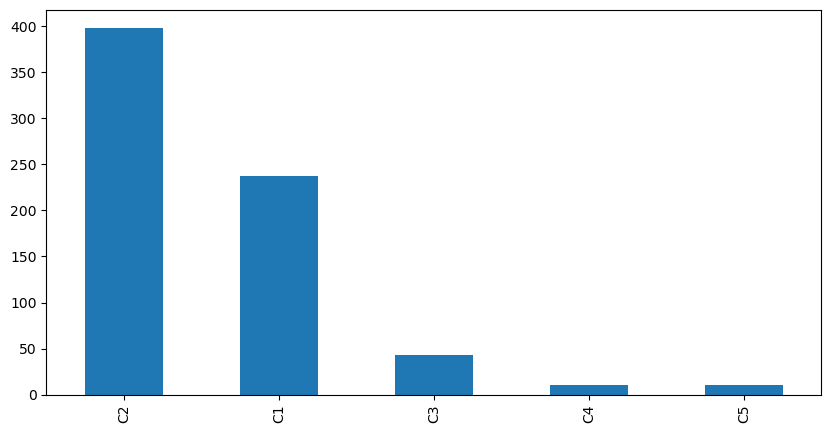

In [11]:
ax_pub = data.classification_diagnostic.value_counts(normalize=False).plot(kind='bar', figsize=(10, 5))

In [12]:
description_features_cat = ['type_sol',
                        'classe_age',
                        'classe_hauteur',
                        'classe_circonference',
                        'vigueur_pousse',
                        'plaie_collet',
                        'fissure_tronc',
                        'plaie_tronc',
                        'fissure_houppier',
                        'bois_mort_houppier',
                        'plaie_houppier',
                        'prescription_1',
                        'prescription_2',
                        'prescription_3',
                        'type_delai_1',
                        'type_delai_2']
description_features_string=  ["ID_ARBRE",
                               'commune',
                               'quartier',
                               'site',
                               'cote_voirie',
                               'genre_arbre',
                               'espece_arbre',
                               'situation',
                               'port_arbre',
                               'champignon_collet',
                               'insecte_collet',
                               'observation_collet',
                               'champignon_tronc',
                               'insecte_tronc',
                               'rejet_tronc',
                               'tuteurage_arbre',
                               'canisse_arbre',
                               'observation_tronc',
                               'champignon_houppier',
                               'insecte_houppier',
                               'ecorce_incluse_houppier',
                               'observation_houppier',
                               'contrainte',
                               'date_diagnostic',
                               'observation_travaux'
                               ]
description_features_num = ['matricule_arbre',
                            'controle',
                            'surf_permeable',
                            'date_plantation',
                            'hauteur',
                            'diametre',
                            'circonference (en cm)',
                            'esperance_maintien',
                            'Long',
                            'Lat'
                            ]
target_features = ['classification_diagnostic']

In [13]:
data[description_features_num]

,matricule_arbre,controle,surf_permeable,date_plantation,hauteur,diametre,circonference (en cm),esperance_maintien,Long,Lat
0,7,NaN,5.0,2000,1000,63.661977,100,1.0,2.074,48.899
1,8,NaN,5.0,2000,1000,60.478878,95,1.0,2.074,48.899
2,9,NaN,5.0,2000,1000,54.112681,85,1.0,2.074,48.899
3,1,NaN,100.0,1980,1600,63.661977,100,1.0,2.073,48.900
4,2,NaN,100.0,1980,1600,190.985932,300,1.0,2.074,48.899
...,...,...,...,...,...,...,...,...,...,...
704,4,NaN,1.0,2000,500,22.281692,35,1.0,2.089,48.898
705,5,NaN,1.0,2017,500,12.732395,20,3.0,2.089,48.899
706,6,NaN,1.0,2000,500,25.464791,40,1.0,2.089,48.899
707,7,NaN,1.0,2019,500,15.915494,25,2.0,2.089,48.899


In [14]:
X_cat= data[description_features_cat]
X_string = data[description_features_string]
X_num = data[description_features_num]
X = pd.concat([X_cat, X_string, X_num], axis=1)
y = data[target_features]

In [16]:
X

,type_sol,classe_age,classe_hauteur,classe_circonference,vigueur_pousse,plaie_collet,fissure_tronc,plaie_tronc,fissure_houppier,bois_mort_houppier,...,matricule_arbre,controle,surf_permeable,date_plantation,hauteur,diametre,circonference (en cm),esperance_maintien,Long,Lat
0,P,A,H2,C2,P,RCPLNS,TPF,TPLNC,HPF,HBMI,...,7,NaN,5.0,2000,1000,63.661977,100,1.0,2.074,48.899
1,P,A,H2,C2,P,RCPPL,TPF,TPLC,HPF,HBMI,...,8,NaN,5.0,2000,1000,60.478878,95,1.0,2.074,48.899
2,P,A,H2,C2,P,RCPPL,TPF,TPLCF,HPF,HBMI,...,9,NaN,5.0,2000,1000,54.112681,85,1.0,2.074,48.899
3,G,A,H4,C2,P,RCPPL,TPF,TPLS,HPF,HBMI,...,1,NaN,100.0,1980,1600,63.661977,100,1.0,2.073,48.900
4,G,A,H4,C6,P,RCPPL,TPF,TPLS,HPF,HBMI,...,2,NaN,100.0,1980,1600,190.985932,300,1.0,2.074,48.899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,Gr,A,H1,C1,P,RCPPL,TPF,TPPL,HPF,HPBM,...,4,NaN,1.0,2000,500,22.281692,35,1.0,2.089,48.898
705,Gr,J,H1,C1,D,RCPPL,TPF,TPPL,HPF,HPBM,...,5,NaN,1.0,2017,500,12.732395,20,3.0,2.089,48.899
706,Gr,A,H1,C1,P,RCPPL,TPF,TPLNC,HPF,HPBM,...,6,NaN,1.0,2000,500,25.464791,40,1.0,2.089,48.899
707,Gr,J,H1,C1,PP,RCPPL,TPF,TPPL,HPF,HPBM,...,7,NaN,1.0,2019,500,15.915494,25,2.0,2.089,48.899


In [17]:
y

,classification_diagnostic
0,C2
1,C2
2,C2
3,C2
4,C2
...,...
704,C2
705,C2
706,C2
707,C2


<Axes: >

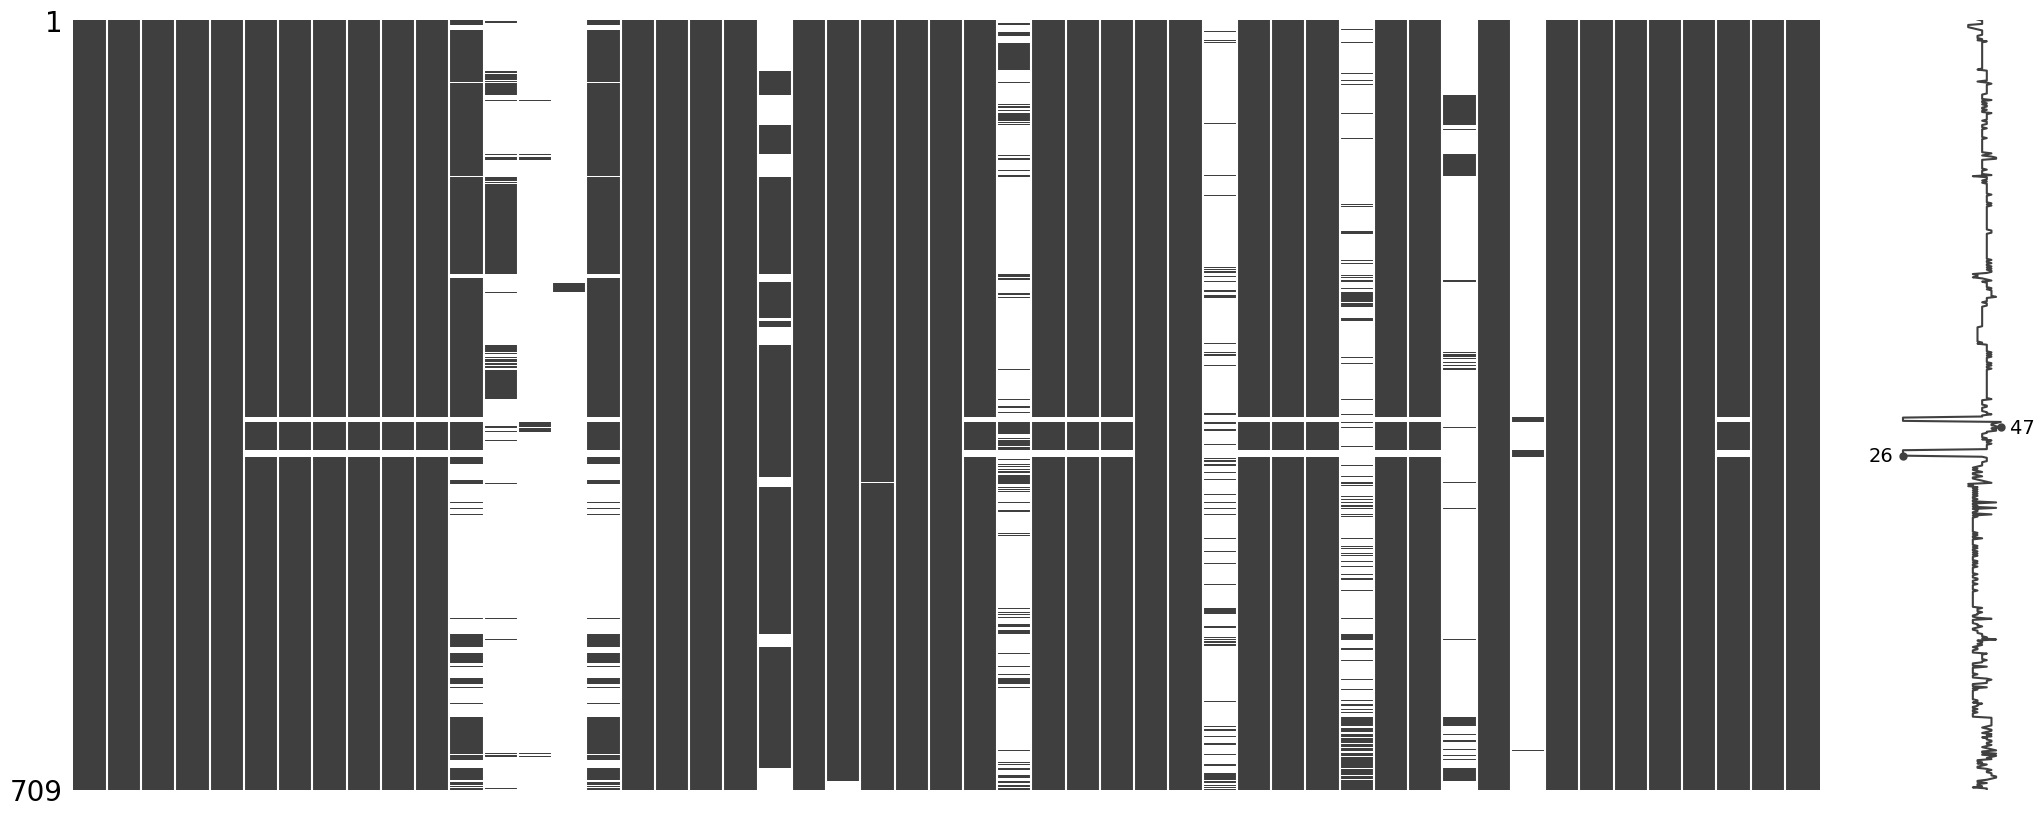

In [18]:
msno.matrix(X)

In [19]:
# Hard code int_to_cat dict and retrieve cat_to_int with dictionary comprehension to use in all needed files
int_to_cat = {
    -1: "NaN",
    0: "C2",
    1: "C1",
    2: "C3",
    3: "C4",
    4: "C5"
}

cat_to_int = {v: k for k, v in int_to_cat.items()}

In [20]:
y_encoded = np.array(y['classification_diagnostic'].map(cat_to_int).fillna(-1).astype('int8'))
np.unique(y_encoded), y_encoded.shape

(array([-1,  0,  1,  2,  3,  4], dtype=int8), (709,))

In [21]:
X_train, X_test, y_train , y_test = train_test_split(X, y_encoded, test_size=0.33, random_state=42)

In [22]:
string_transformer = ColumnTransformer(
    [("string", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1000), description_features_string),
     ("cat", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1000), description_features_cat)])

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
             ("scaler", StandardScaler())]
)
clf = Pipeline(
    steps=[("encoder", string_transformer),
        ("transformer", numeric_transformer),
        ("classifier", RandomForestClassifier(random_state=42))]
)
clf.fit(X_train, y_train)
clf

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('string',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1000),
                                                  ['ID_ARBRE', 'commune',
                                                   'quartier', 'site',
                                                   'cote_voirie', 'genre_arbre',
                                                   'espece_arbre', 'situation',
                                                   'port_arbre',
                                                   'champignon_collet',
                                                   'insecte_collet',
                                                   'observation_collet',
                                                   'champignon_tronc',
                                                   'insecte_tronc',
                                                   'rejet_tr...
                                                   'plaie_collet',
                                                   'fissure_tronc',
                                                   'plaie_tronc',
                                                   'fissure_houppier',
                                                   'bois_mort_houppier',
                                                   'plaie_houppier',
                                                   'prescription_1',
                                                   'prescription_2',
                                                   'prescription_3',
                                                   'type_delai_1',
                                                   'type_delai_2'])])),
                ('transformer',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('scaler', StandardScaler())])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [23]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8461538461538461

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         4
           0       0.82      0.92      0.87       120
           1       0.88      0.91      0.90        89
           2       1.00      0.18      0.30        17
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2

    accuracy                           0.85       234
   macro avg       0.62      0.50      0.51       234
weighted avg       0.85      0.85      0.82       234



c:\Users\yanis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


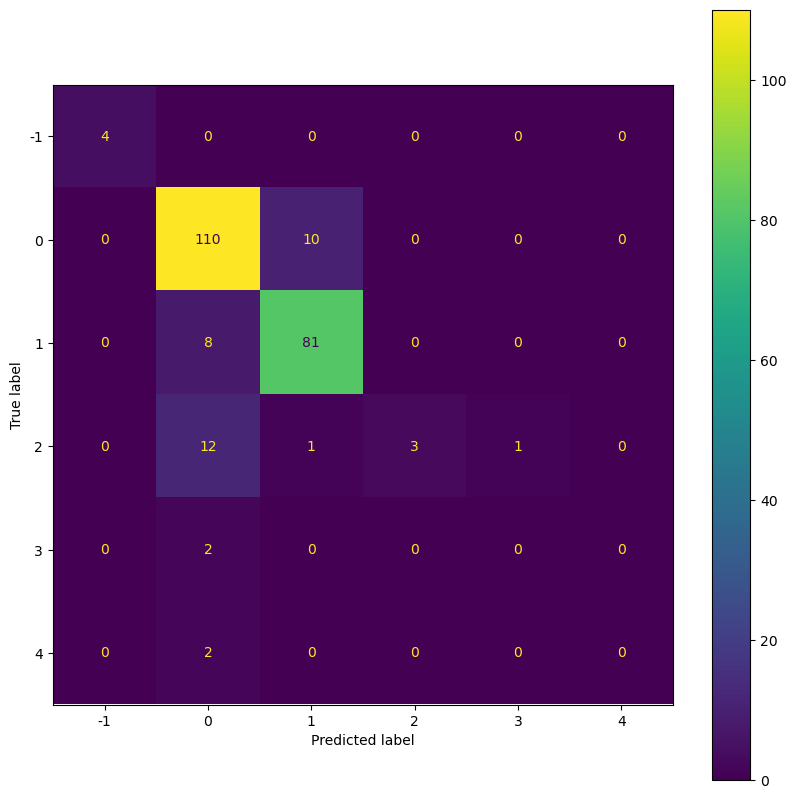

In [25]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)  

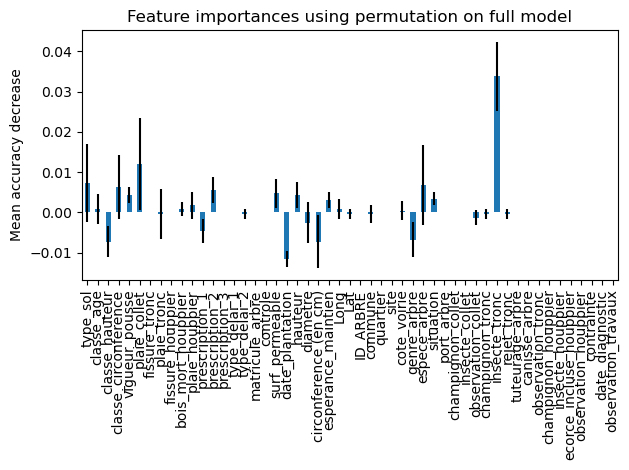

In [26]:
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean,
                                index=description_features_cat+
                               description_features_num+
                               description_features_string)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [27]:
balanced_accuracy_score(y_test, y_pred)

0.5005416024087538

### Submit

In [28]:
%%writefile submissions/starting_kit/classifier.py

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

description_features_cat = ["type_sol",
                            'classe_age',
                            'classe_hauteur',
                            'classe_circonference',
                            'vigueur_pousse',
                            'plaie_collet',
                            'fissure_tronc',
                            'plaie_tronc',
                            'fissure_houppier',
                            'bois_mort_houppier',
                            'plaie_houppier',
                            'prescription_1',
                            'prescription_2',
                            'prescription_3',
                            'type_delai_1',
                            'type_delai_2']
description_features_string = ["ID_ARBRE",
                               'commune',
                               'quartier',
                               'site',
                               'cote_voirie',
                               'genre_arbre',
                               'espece_arbre',
                               'situation',
                               'port_arbre',
                               'champignon_collet',
                               'insecte_collet',
                               'observation_collet',
                               'champignon_tronc',
                               'insecte_tronc',
                               'rejet_tronc',
                               'tuteurage_arbre',
                               'canisse_arbre',
                               'observation_tronc',
                               'champignon_houppier',
                               'insecte_houppier',
                               'ecorce_incluse_houppier',
                               'observation_houppier',
                               'contrainte',
                               'date_diagnostic',
                               'observation_travaux'
                               ]
description_features_num = ['matricule_arbre',
                            'controle',
                            'surf_permeable',
                            'date_plantation',
                            'hauteur',
                            'diametre',
                            'circonference (en cm)',
                            'esperance_maintien',
                            'Long',
                            'Lat'
                            ]
target_features = ['classification_diagnostic']


class Classifier(BaseEstimator):
    def __init__(self):
        self.string_transformer = ColumnTransformer(
            [("string",
              OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1000),
              description_features_string),
             ("cat",
              OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1000), description_features_cat)])

        self.numeric_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="most_frequent")),
                   ("scaler", StandardScaler())])

        self.model = RandomForestClassifier(random_state=42)

        self.pipe = make_pipeline(
            self.string_transformer,
            self.numeric_transformer,
            self.model)

    def fit(self, X, y):
        self.pipe.fit(X, y)

    def predict(self, X):
        return self.pipe.predict(X)

    def predict_proba(self, X):
        return self.pipe.predict_proba(X)
    

Overwriting submissions/starting_kit/classifier.py


In [29]:
#!pip install ramp-workflow

In [30]:
!ramp-test --submission starting_kit

Testing Urban trees: towards a clinical study
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions\starting_kit ...
CV fold 0


Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\yanis\anaconda3\Scripts\ramp-test.exe\__main__.py", line 7, in <module>
  File "C:\Users\yanis\anaconda3\Lib\site-packages\rampwf\utils\cli\testing.py", line 117, in start
    main()
  File "C:\Users\yanis\anaconda3\Lib\site-packages\click\core.py", line 1128, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yanis\anaconda3\Lib\site-packages\click\core.py", line 1053, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "C:\Users\yanis\anaconda3\Lib\site-packages\click\core.py", line 1395, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yanis\anaconda3\Lib\site-packages\click\core.py", line 754, in invoke
    return __callback(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
 